# 训练

In [1]:
# ./scripts/mmyolo_train.sh yolov5n 10

In [1]:
gpu_id = 0

# 变量定义

In [2]:
import glob
import os

# 参数
model_name = 'yolov5'
model_stru = 'n'
model_cfg = ''
img_size = 640
exp_name = f'{model_name}{model_stru}{model_cfg}_{img_size}'

# 路径
cfg_path = f'cfg/mmyolo/{exp_name}.py'
best_model_path = f'runs/mmyolo/{exp_name}/train/'
exp_id = max([f for f in os.listdir(best_model_path) if os.path.isdir(os.path.join(best_model_path, f))])  # 最新实验
files = glob.glob(f'{best_model_path}/best_coco_bbox_mAP_epoch_*.pth')  # TODO: 按epoch数排序
best_model_path = files[0] if files else None
train_log_path = f'runs/mmyolo/{exp_name}/train/{exp_id}/vis_data/scalars.json'

print(f'{exp_name=}')
print(f'{best_model_path=}')
print(f'{train_log_path=}')


exp_name='yolov5n_640'
best_model_path='runs/mmyolo/yolov5n_640/train/best_coco_bbox_mAP_epoch_263.pth'
train_log_path='runs/mmyolo/yolov5n_640/train/20240307_213915/vis_data/scalars.json'


# 日志分析

['base_lr', 'lr', 'data_time', 'loss', 'loss_cls', 'loss_obj', 'loss_bbox', 'time', 'iter', 'memory', 'step']
['coco/bbox_mAP', 'coco/bbox_mAP_50', 'coco/bbox_mAP_75', 'coco/bbox_mAP_s', 'coco/bbox_mAP_m', 'coco/bbox_mAP_l', 'data_time', 'time']
最大map: (263)0.939


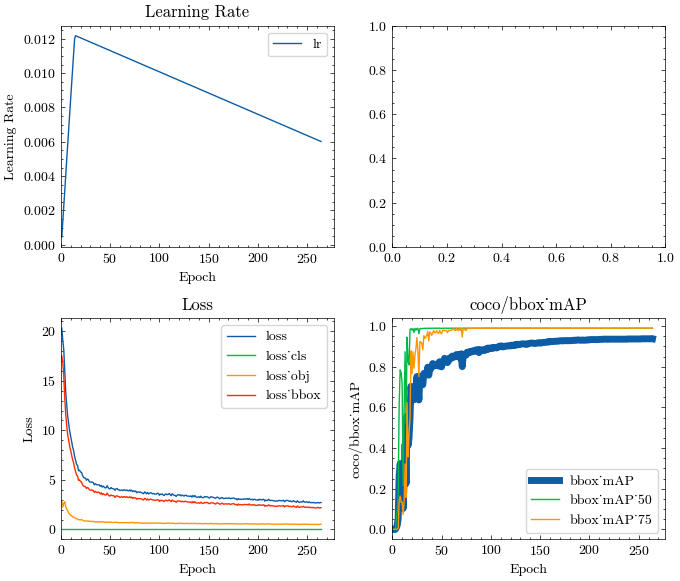

In [3]:
from src.utils.read import read_mmdet_train_log_json
from src.utils.plot import plot_mmyolo_yolov5_train_log

df_train, df_val = read_mmdet_train_log_json(train_log_path)
plot_mmyolo_yolov5_train_log(df_train, df_val, exp_name=exp_name)

# 测试

In [4]:
! scripts/mmyolo_test.sh {cfg_path} {best_model_path} {exp_name} {gpu_id}

06/03 02:10:26 - mmengine - WARNING - Failed to search registry with scope "mmyolo" in the "log_processor" registry tree. As a workaround, the current "log_processor" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmyolo" is a correct scope, or whether the registry is initialized.
06/03 02:10:27 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:23:11) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: NVIDIA GeForce RTX 3090
    CUDA_HOME: None
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.1.0+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Int

# 评估

In [5]:
# 提供两种测试评价方案，结果一致
# 方式1: pycocotools
import pandas as pd
from src.utils.metric import coco_metrics_name
from src.utils.metric import cal_coco_metrics

# 保存评价结果对象
coco_evals = {}
# 构造dataframe
all_metrics = {}

# 在各测试集进行推理
for data_type in ['test_synth', 'test_real_nominal', 'test_real_edge', 'test_real', 'test']:

    print(f'正在评价: {data_type}')
    annotation_file = f'datasets/lard/annotations/instances_{data_type}.json'
    prediction_file = f'runs/mmyolo/{exp_name}/test/coco_detection/prediction_{data_type}.bbox.json'
    cocoEval = cal_coco_metrics(annotation_file, prediction_file)
    coco_evals[data_type] = cocoEval
    all_metrics[data_type] = cocoEval.stats

all_metrics = pd.DataFrame(all_metrics, index=coco_metrics_name)
display(all_metrics.round(3))


# 方式2: eval_metric.py
# ! python 3rdparty/mmdetection/tools/analysis_tools/eval_metric.py \
#     {cfg_path} \
#     runs/mmdetection/{exp_name}/test/coco_detection/prediction_test_synth.pkl \
#     --cfg-options \
#     test_evaluator.format_only=False

正在评价: test_synth
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.60s).
Accumulating evaluation results...
DONE (t=0.12s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.706
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.947
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.822
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.604
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.755
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.753
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.756
 Average Recall     (AR) @[ IoU=0.50:0.95 | are

,test_synth,test_real_nominal,test_real_edge,test_real,test
"AP (IoU=0.50:0.95, area=all, maxDets=100)",0.706,0.540,0.302,0.499,0.614
"AP (IoU=0.50, area=all, maxDets=100)",0.947,0.824,0.509,0.771,0.869
"AP (IoU=0.75, area=all, maxDets=100)",0.822,0.586,0.325,0.541,0.696
"AP (IoU=0.50:0.95, area=small, maxDets=100)",-1.000,0.163,0.033,0.144,0.143
"AP (IoU=0.50:0.95, area=medium, maxDets=100)",0.604,0.421,0.225,0.392,0.500
"AP (IoU=0.50:0.95, area=large, maxDets=100)",0.755,0.734,0.392,0.665,0.722
"AR (IoU=0.50:0.95, area=all, maxDets=1)",0.753,0.572,0.331,0.530,0.653
"AR (IoU=0.50:0.95, area=all, maxDets=10)",0.756,0.589,0.346,0.547,0.662
"AR (IoU=0.50:0.95, area=all, maxDets=100)",0.756,0.589,0.346,0.547,0.662
"AR (IoU=0.50:0.95, area=small, maxDets=100)",-1.000,0.205,0.067,0.184,0.184


In [7]:
# from src.utils.plot import plot_pr_curve

# plot_pr_curve(coco_evals, iou_indices=[0, 2, 4, 6, 8], exp_name=exp_name)

# 参数量

In [6]:
# ! scripts/mmyolo_flops.sh {cfg_path} {img_size}

import argparse
import importlib
import pandas as pd
from mmengine.logging import MMLogger


module = importlib.import_module("3rdparty.mmyolo.tools.analysis_tools.get_flops")
inference = module.inference

args = argparse.Namespace(
    config=cfg_path,
    shape=[img_size],
    show_arch=False,
    not_show_table=True,
    cfg_options=dict()
)

logger = MMLogger.get_instance(name='MMLogger')
result = inference(args, logger)

split_line = '=' * 30

ori_shape = result['ori_shape']
pad_shape = result['pad_shape']
flops = result['flops']
params = result['params']

print(result['out_table'])  # print related information by table
print(result['out_arch'])  # print related information by network layers

if pad_shape != ori_shape:
    print(f'{split_line}\nUse size divisor set input shape '
            f'from {ori_shape} to {pad_shape}')

print(f'{split_line}\n'
        f'Input shape: {pad_shape}\nModel Flops: {flops}\n'
        f'Model Parameters: {params}\n{split_line}')

# 数据重构
all_complex = {}
for data_type in ['test_synth', 'test_real_nominal', 'test_real_edge', 'test_real', 'test']:
    all_complex[data_type] = [params, flops]  # 仅为便于数据拼接
all_complex = pd.DataFrame(
    data=all_complex,
    index=['Param', 'FLOPs']
)

# 合并复杂度指标
all_metrics = pd.concat([all_metrics, all_complex], axis=0)
all_metrics.round(3)

!!!You are using `YOLOv5Head` with num_classes == 1. The loss_cls will be 0. This is a normal phenomenon.
Switch model to deploy modality.
06/03 02:23:10 - mmengine - WARNING - Unsupported operator aten::silu_ encountered 57 time(s)
06/03 02:23:10 - mmengine - WARNING - Unsupported operator aten::add encountered 7 time(s)
06/03 02:23:10 - mmengine - WARNING - Unsupported operator aten::max_pool2d encountered 3 time(s)
06/03 02:23:10 - mmengine - WARNING - The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.
bbox_head.loss_bbox, bbox_head.loss_cls, bbox_head.loss_obj, data_preprocessor
06/03 02:23:10 - mmengine - WARNING - Unsupported operator aten::batch_norm encountered 57 time(s)
06/03 02:23:10 - mmengine - WARNING - Un

,test_synth,test_real_nominal,test_real_edge,test_real,test
"AP (IoU=0.50:0.95, area=all, maxDets=100)",0.706,0.540,0.302,0.499,0.614
"AP (IoU=0.50, area=all, maxDets=100)",0.947,0.824,0.509,0.771,0.869
"AP (IoU=0.75, area=all, maxDets=100)",0.822,0.586,0.325,0.541,0.696
"AP (IoU=0.50:0.95, area=small, maxDets=100)",-1.000,0.163,0.033,0.144,0.143
"AP (IoU=0.50:0.95, area=medium, maxDets=100)",0.604,0.421,0.225,0.392,0.500
"AP (IoU=0.50:0.95, area=large, maxDets=100)",0.755,0.734,0.392,0.665,0.722
"AR (IoU=0.50:0.95, area=all, maxDets=1)",0.753,0.572,0.331,0.530,0.653
"AR (IoU=0.50:0.95, area=all, maxDets=10)",0.756,0.589,0.346,0.547,0.662
"AR (IoU=0.50:0.95, area=all, maxDets=100)",0.756,0.589,0.346,0.547,0.662
"AR (IoU=0.50:0.95, area=small, maxDets=100)",-1.000,0.205,0.067,0.184,0.184


# 测速

In [7]:
! scripts/mmyolo_speed.sh {cfg_path} {best_model_path} {gpu_id}

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
!!!You are using `YOLOv5Head` with num_classes == 1. The loss_cls will be 0. This is a normal phenomenon.
Loads checkpoint by local backend from path: runs/mmyolo/yolov5n_640/train/best_coco_bbox_mAP_epoch_263.pth
06/03 02:23:57 - mmengine - INFO - Done image [500/ 2000], fps: 98.1 img / s, times per image: 10.2 ms / img
06/03 02:24:32 - mmengine - INFO - Done image [1000/ 2000], fps: 98.5 img / s, times per image: 10.2 ms / img
06/03 02:25:08 - mmengine - INFO - Done image [1500/ 2000], fps: 99.4 img / s, times per image: 10.1 ms / img
06/03 02:25:43 - mmengine - INFO - Done image [2000/ 2000], fps: 99.0 img / s, times per image: 10.1 ms / img
06/03 02:25:43 - mmengine - INFO - Overall fps: 99.0 img / s, times per image: 10.1 ms / img
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
!!!You are using `YOLOv5Head` with num_classes == 1. The loss_cls will be 0. This is a n

In [14]:
# 06/03 02:23:57 - mmengine - INFO - Done image [500/ 2000], fps: 98.1 img / s, times per image: 10.2 ms / img
# 06/03 02:26:35 - mmengine - INFO - Done image [500/ 2000], fps: 98.1 img / s, times per image: 10.2 ms / img
# 06/03 02:28:22 - mmengine - INFO - Done image [100/ 2000], fps: 107.9 img / s, times per image: 9.3 ms / img
# 06/03 02:29:36 - mmengine - INFO - Done image [500/ 2000], fps: 97.6 img / s, times per image: 10.2 ms / img
# 06/03 02:32:30 - mmengine - INFO - Done image [500/ 2000], fps: 99.0 img / s, times per image: 10.1 ms / img

In [8]:
# 保存结果
all_speed = {
    'test_synth': [10.2, 98.1],  # [average_time, fps]
    'test_real_nominal': [10.2, 98.1],
    'test_real_edge': [9.3, 107.9],
    'test_real': [10.2, 97.6],
    'test': [10.1, 99.0]
}

# 构建dataframe
all_speed = pd.DataFrame(
    data=all_speed,
    index=['Time', 'FPS']
)

# 合并测试指标
all_metrics = pd.concat([all_metrics, all_speed], axis=0)
all_metrics.round(3)

,test_synth,test_real_nominal,test_real_edge,test_real,test
"AP (IoU=0.50:0.95, area=all, maxDets=100)",0.706,0.540,0.302,0.499,0.614
"AP (IoU=0.50, area=all, maxDets=100)",0.947,0.824,0.509,0.771,0.869
"AP (IoU=0.75, area=all, maxDets=100)",0.822,0.586,0.325,0.541,0.696
"AP (IoU=0.50:0.95, area=small, maxDets=100)",-1.000,0.163,0.033,0.144,0.143
"AP (IoU=0.50:0.95, area=medium, maxDets=100)",0.604,0.421,0.225,0.392,0.500
"AP (IoU=0.50:0.95, area=large, maxDets=100)",0.755,0.734,0.392,0.665,0.722
"AR (IoU=0.50:0.95, area=all, maxDets=1)",0.753,0.572,0.331,0.530,0.653
"AR (IoU=0.50:0.95, area=all, maxDets=10)",0.756,0.589,0.346,0.547,0.662
"AR (IoU=0.50:0.95, area=all, maxDets=100)",0.756,0.589,0.346,0.547,0.662
"AR (IoU=0.50:0.95, area=small, maxDets=100)",-1.000,0.205,0.067,0.184,0.184


In [9]:
all_metrics.index.name = 'metrics'
all_metrics.to_csv(
    f'results/tables/metrics/baseline/metrics_baseline_{exp_name}.csv', 
    float_format='%.3f')

# 写入检测结果

In [ ]:
# from src.utils.database import write_detections_2_database
# write_detections_2_database(lib_type='mmyolo', exp_name=exp_name)


In [ ]:
# from src.utils.database import delete_detections_from_database
# delete_detections_from_database(exp_name=exp_name)
